In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.indicators.hv import Hypervolume

# MODELAGEM

Constantes.

In [2]:
SEED=42
INDICADOR_DEV_DISPONIVEL = 'INDEFINIDO'
#
# DATASETS
ENDERECO_DATASET_DESENVOLVEDORES = 'space_dataset_final_anonimizado.csv'
ENDERECO_DATASET_SOLUCOES_ENCONTRADAS = './solucoes/solucoes_encontradas'
#
# LOGS
ENDERECO_LOG_OTIMIZACAO = './log/log_otimizacao'
#
# HYPERVOLUME
ENDERECO_HYPERVOLUME_SOLUCOES_ENCONTRADAS = './hypervolume/hypervolume.csv'
#
# OTIMIZAÇÃO
TAMANHO_POPULACAO_INICIAL = 1250
PERCENTUAL_DESCENDENTES_EM_RELACAO_AO_TAMANHO_DA_POPULACAO_INICIAL = 0.7
QUANTIDADE_DE_GERACOES_QUE_DEFINEM_O_TERMINO_DA_OTIMIZACAO = 1000
#
# CALCULADAS
QUANTIDADE_DESCENDENTES = int(round(TAMANHO_POPULACAO_INICIAL * PERCENTUAL_DESCENDENTES_EM_RELACAO_AO_TAMANHO_DA_POPULACAO_INICIAL))
RESUMO_EXECUCAO = { 'POP_SIZE' : TAMANHO_POPULACAO_INICIAL, 'N_OFFSPRINGS': QUANTIDADE_DESCENDENTES, 'N_GEN': QUANTIDADE_DE_GERACOES_QUE_DEFINEM_O_TERMINO_DA_OTIMIZACAO }
IDENTIFICADOR_EXECUCAO = ''.join([ '.' + key + '_' + str(RESUMO_EXECUCAO[key]) for key in RESUMO_EXECUCAO ])

Dataset **original**.

In [3]:
df = pd.read_csv(ENDERECO_DATASET_DESENVOLVEDORES, sep=";", index_col=0)
df.head()

,TIME,SATISFACAO,ATIVIDADE,COMUNICACAO
ID,,,,
Dev_0,roslyn,0.268889,1.000000,0.666392
Dev_5,eShop,0.224624,0.383788,1.000000
Dev_7,winforms,0.168448,0.312729,0.473504
Dev_8,sdk,0.106713,0.306179,0.143328
Dev_10,INDEFINIDO,0.154821,0.283167,0.176002


In [4]:
df.describe()

,SATISFACAO,ATIVIDADE,COMUNICACAO
count,180.000000,180.000000,180.000000
mean,0.177680,0.091989,0.185338
std,0.069927,0.092295,0.149458
min,0.097971,0.029857,0.038990
25%,0.128479,0.044177,0.084878
50%,0.160290,0.065484,0.152046
75%,0.204350,0.108695,0.222680
max,0.546701,1.000000,1.000000


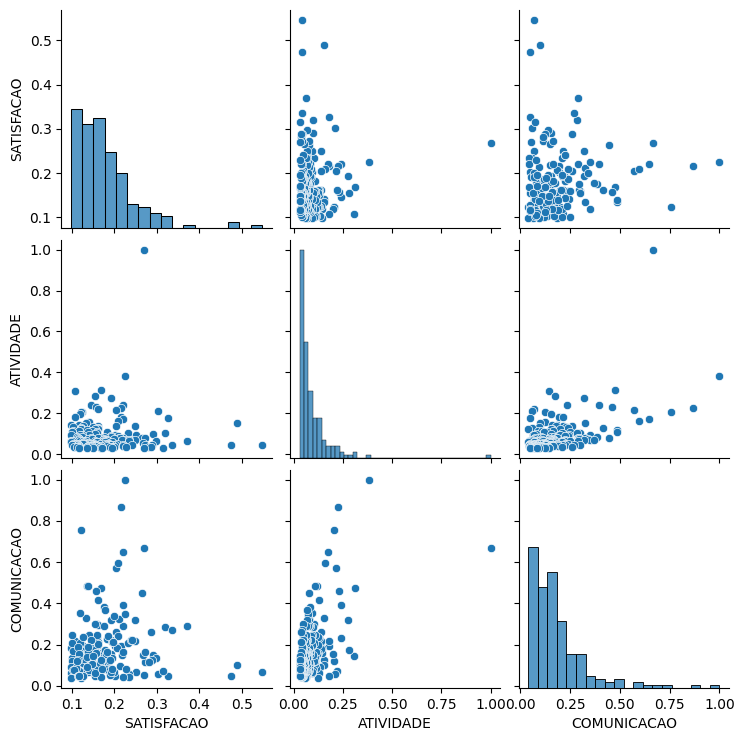

In [5]:
sns.pairplot(df[['SATISFACAO', 'ATIVIDADE', 'COMUNICACAO']])

Dataset dos **novos desenvolvedores**.

In [6]:
df_novos = df[df['TIME'] == INDICADOR_DEV_DISPONIVEL].copy()
df_novos.head()

,TIME,SATISFACAO,ATIVIDADE,COMUNICACAO
ID,,,,
Dev_10,INDEFINIDO,0.154821,0.283167,0.176002
Dev_19,INDEFINIDO,0.161245,0.221989,0.070154
Dev_21,INDEFINIDO,0.302277,0.210303,0.056974
Dev_26,INDEFINIDO,0.118872,0.198137,0.154448
Dev_30,INDEFINIDO,0.215128,0.181187,0.194124


In [7]:
df_novos.describe()

,SATISFACAO,ATIVIDADE,COMUNICACAO
count,33.000000,33.000000,33.000000
mean,0.172479,0.098260,0.164844
std,0.057020,0.065794,0.110114
min,0.103148,0.030727,0.046952
25%,0.127478,0.047657,0.093081
50%,0.160264,0.072938,0.155409
75%,0.205855,0.138831,0.190143
max,0.325860,0.283167,0.648407


Dataset dos **desenvolvedores atuais**.

In [8]:
df_atuais = df[df['TIME'] != INDICADOR_DEV_DISPONIVEL].copy()
df_atuais.head()

,TIME,SATISFACAO,ATIVIDADE,COMUNICACAO
ID,,,,
Dev_0,roslyn,0.268889,1.000000,0.666392
Dev_5,eShop,0.224624,0.383788,1.000000
Dev_7,winforms,0.168448,0.312729,0.473504
Dev_8,sdk,0.106713,0.306179,0.143328
Dev_11,aspnetcore,0.193292,0.273496,0.321527


In [9]:
df_atuais.describe()

,SATISFACAO,ATIVIDADE,COMUNICACAO
count,147.000000,147.000000,147.000000
mean,0.178847,0.090581,0.189939
std,0.072629,0.097387,0.156884
min,0.097971,0.029857,0.038990
25%,0.132075,0.043251,0.084775
50%,0.160580,0.065276,0.147996
75%,0.202909,0.106028,0.231054
max,0.546701,1.000000,1.000000


Estado atual da variabilidade das dimensões de SATISFACAO, ATIVIDADE e COMUNICACAO.

In [10]:
variabilidade_atual = df_atuais \
    .groupby(['TIME'])[['SATISFACAO', 'ATIVIDADE', 'COMUNICACAO']] \
    .sum() \
    .sort_values(by=['SATISFACAO', 'ATIVIDADE', 'COMUNICACAO'], ascending=False) \
    .std()
variabilidade_atual

SATISFACAO     1.066996
ATIVIDADE      0.481823
COMUNICACAO    0.919604
dtype: float64

Visualização 3D da variabilidade atual.

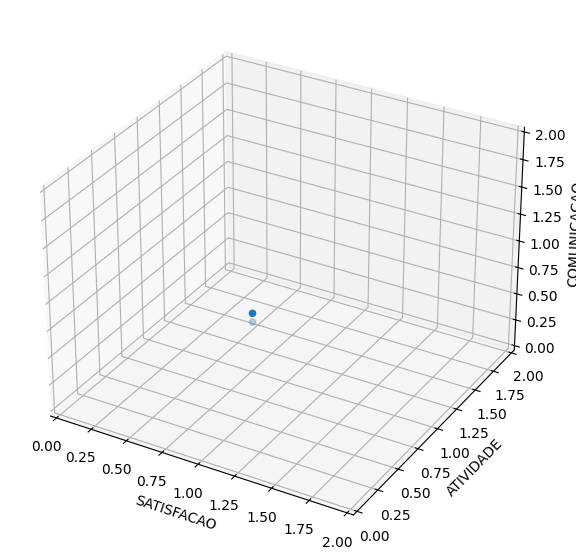

In [11]:
x = np.array(variabilidade_atual['SATISFACAO'])
y = np.array(variabilidade_atual['ATIVIDADE'])
z = np.array([[1, variabilidade_atual['COMUNICACAO']]])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('SATISFACAO')
ax.set_ylabel('ATIVIDADE')
ax.set_zlabel('COMUNICACAO')

ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_zlim(0, 2)

p = ax.scatter(x, y, z, marker='o')

-----

In [12]:
print('Varibilidade que considera também o grupo INDEFINIDO. Não é o estado atual da empresa, portanto.')
df.groupby('TIME')[['SATISFACAO', 'ATIVIDADE', 'COMUNICACAO']].sum().std()

Varibilidade que considera também o grupo INDEFINIDO. Não é o estado atual da empresa, portanto.


SATISFACAO     1.375253
ATIVIDADE      0.702518
COMUNICACAO    1.227839
dtype: float64

Definindo o problema em termos da biblioteca *pymoo*.

In [13]:
class ProblemaAlocacaoDev(ElementwiseProblem):

    def __init__(self, df):
        self.times, self.novos, self.atuais = self.dividir_devs_em_times_novos_e_atuais(df)
        super().__init__(
            n_var = len(self.times),
            n_obj=3
        )

    def _evaluate(self, x, out, *args, **kwargs):
        f_variab_satisfacao, f_variab_atividade, f_variab_comunicacao =  self.calcular_variabilidade_da_solucao(x)
        out["F"] = [f_variab_satisfacao, f_variab_atividade, f_variab_comunicacao]

    def dividir_devs_em_times_novos_e_atuais(self, df):
        atuais = df[df['TIME'] != INDICADOR_DEV_DISPONIVEL].reset_index()
        novos = df[df['TIME'] == INDICADOR_DEV_DISPONIVEL].reset_index()
        times = list(df.groupby('TIME').groups)
        [times.append(INDICADOR_DEV_DISPONIVEL) for x in range(len(novos.values) - len(times))]
        return times, novos, atuais

    def calcular_variabilidade_da_solucao(self, x):
        df_atuais_e_novos = self.criar_solucao(x)
        desv_pad = df_atuais_e_novos.groupby('TIME')[['SATISFACAO', 'ATIVIDADE', 'COMUNICACAO']].sum().std()
        return desv_pad['SATISFACAO'], desv_pad['ATIVIDADE'], desv_pad['COMUNICACAO']

    def criar_solucao(self, x):
        df_novos_temp = self.novos.copy()
        for i in range(len(x)):
            df_novos_temp.loc[i, 'TIME'] = self.times[x[i]]
        return pd.concat([self.atuais.copy(), df_novos_temp])

Instanciando o algoritmo.

In [14]:
algoritmo = NSGA2(
    pop_size=TAMANHO_POPULACAO_INICIAL,
    n_offsprings=QUANTIDADE_DESCENDENTES,
    sampling=PermutationRandomSampling(),
    crossover=OrderCrossover(shift=True),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

Definindo critério de parada.

In [15]:
criterio_termino = get_termination('n_gen', QUANTIDADE_DE_GERACOES_QUE_DEFINEM_O_TERMINO_DA_OTIMIZACAO)

Executando procedimento de minimização.

In [16]:
problema = ProblemaAlocacaoDev(df)

In [17]:
inicio_execucao = datetime.now()

In [18]:
%%capture captura_log_otimizacao
resultado = minimize(
    problema,
    algoritmo,
    criterio_termino,
    seed=SEED,
    save_history=True,
    verbose=True
)

In [19]:
with open(f'{ENDERECO_LOG_OTIMIZACAO}{IDENTIFICADOR_EXECUCAO}.log', 'w') as log:
    log.write(f'[OTIMIZACAO][PARAMETROS][TAMANHO_POPULACAO_INICIAL]={TAMANHO_POPULACAO_INICIAL}\n')
    log.write(f'[OTIMIZACAO][PARAMETROS][QUANTIDADE_DESCENDENTES]={QUANTIDADE_DESCENDENTES}\n')
    log.write(f'[OTIMIZACAO][PARAMETROS][QUANTIDADE_GERACOES_TERMINO_OTIMIZACAO]={QUANTIDADE_DE_GERACOES_QUE_DEFINEM_O_TERMINO_DA_OTIMIZACAO}\n')
    log.write(f'\n[OTIMIZACAO][INICIO]={str(inicio_execucao)}\n')
    log.write(f'\n{captura_log_otimizacao.stdout}\n')
    log.write(f'\n[OTIMIZACAO][FIM]={str(datetime.now())}\n')

In [20]:
X = resultado.X
F = resultado.F

Exibindo algumas soluções.

In [21]:
print('No total, temos um número X de soluções para cada um dos 33 desenvolvedores sem time definido.')
X.shape

No total, temos um número X de soluções para cada um dos 33 desenvolvedores sem time definido.


(964, 33)

In [22]:
print('Aqui vemos as primeiras soluções.')
X[:5]

Aqui vemos as primeiras soluções.


array([[20, 21,  6, 30, 22, 26, 14, 12, 25, 24,  1, 29,  2,  5, 11, 19,
        15, 13, 18,  0,  3, 16, 27, 23, 10,  7, 31, 32,  8,  4,  9, 28,
        17],
       [19, 22,  1,  7,  8, 10, 26, 25, 11, 17, 21, 30,  6, 32, 29, 14,
         3, 20,  5, 15, 28, 27, 12, 23, 13, 24,  0,  4, 16, 31, 18,  2,
         9],
       [ 8, 12,  3, 18,  7, 11, 14, 21, 19, 28, 26, 10,  1, 29, 15, 20,
        31, 25, 13, 32,  9, 27,  2, 24, 16, 17, 23,  0,  6, 22,  4, 30,
         5],
       [20, 12,  8, 29, 13,  3, 14,  1, 26,  6, 21, 16,  7, 31, 11, 10,
         9, 22, 18, 19, 15, 28, 17, 24, 25,  2,  0, 30, 32,  5,  4, 27,
        23],
       [10, 12, 27, 30, 25,  3, 14, 21,  1, 17, 20,  8, 31, 13, 22, 26,
        29, 19, 18,  7,  5,  2, 32, 24, 16, 15,  0, 28, 11,  6,  9,  4,
        23]])

Exibindo algumas variabilidades.

Há um número X de soluções e, para cada uma delas, há 3 valores de variabilidade associados a cada uma das 3 dimensões SPACE avaliadas.

In [23]:
F.shape

(964, 3)

In [24]:
print('Estas são algumas variabilidades encontradas. Cada grupo de 3 representa uma solução possível para o problema.')
F[:5]

Estas são algumas variabilidades encontradas. Cada grupo de 3 representa uma solução possível para o problema.


array([[1.02019872, 0.45669965, 0.87095352],
       [1.0197841 , 0.45001755, 0.87381885],
       [1.03234469, 0.45009136, 0.84705444],
       [1.02805074, 0.4444422 , 0.85719853],
       [1.02972422, 0.45426526, 0.84466639]])

Visualizando o espaço de projeto.

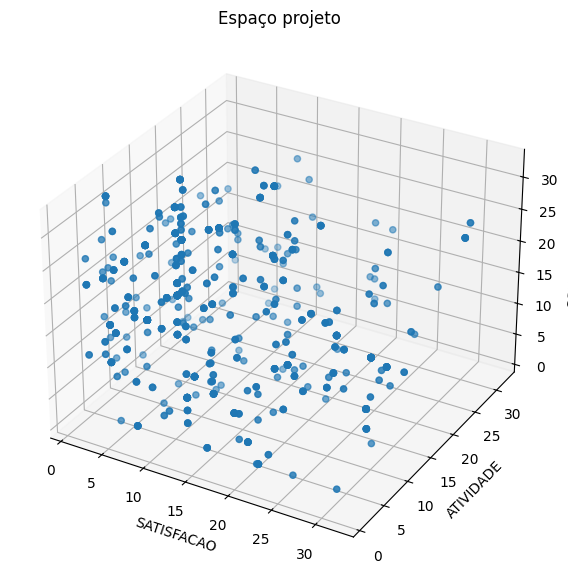

In [25]:
x = np.array(X[:, 0])
y = np.array(X[:, 1])
z = np.array([X[:, 2]])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('SATISFACAO')
ax.set_ylabel('ATIVIDADE')
ax.set_zlabel('COMUNICACAO')

ax.set_title("Espaço projeto")

p = ax.scatter(x, y, z, marker='o')


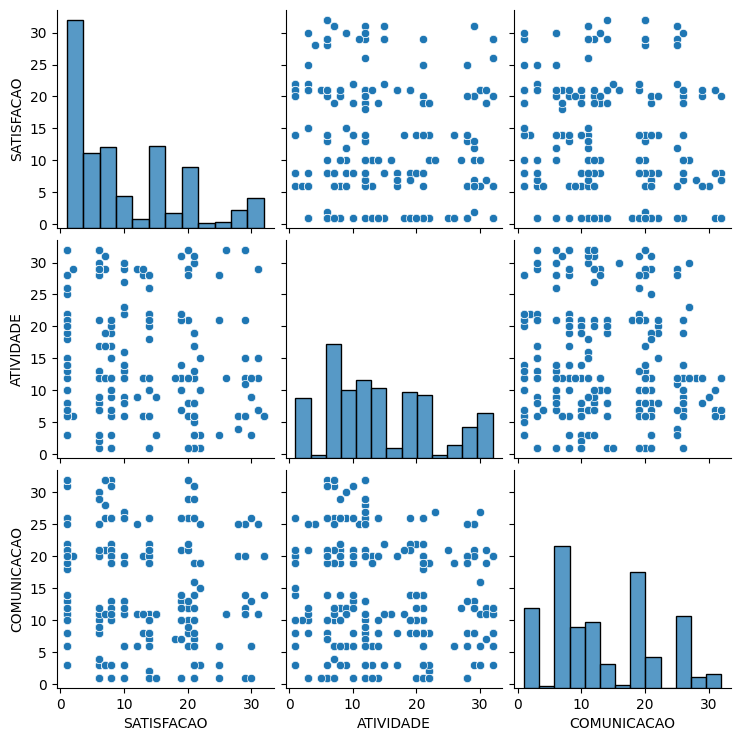

In [26]:
sns.pairplot(pd.DataFrame(data={ 'SATISFACAO': X[:, 0], 'ATIVIDADE': X[:, 1], 'COMUNICACAO': X[:, 2]}))

Visualizando o espaço de objetivo.

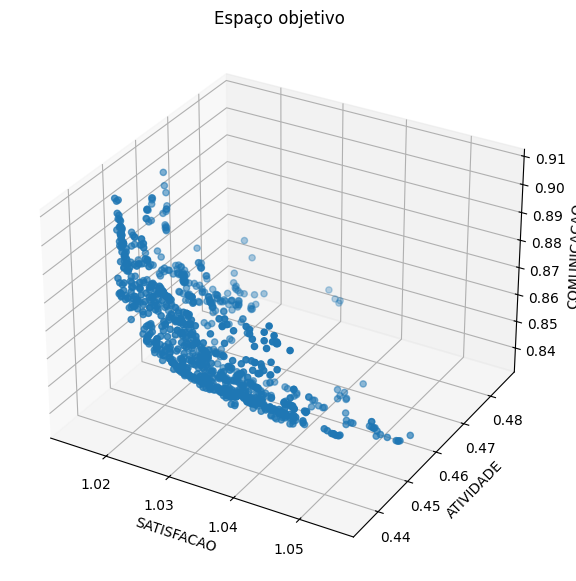

In [27]:
x = np.array(F[:, 0])
y = np.array(F[:, 1])
z = np.array([F[:, 2]])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('SATISFACAO')
ax.set_ylabel('ATIVIDADE')
ax.set_zlabel('COMUNICACAO')

ax.set_title("Espaço objetivo")

p = ax.scatter(x, y, z, marker='o')

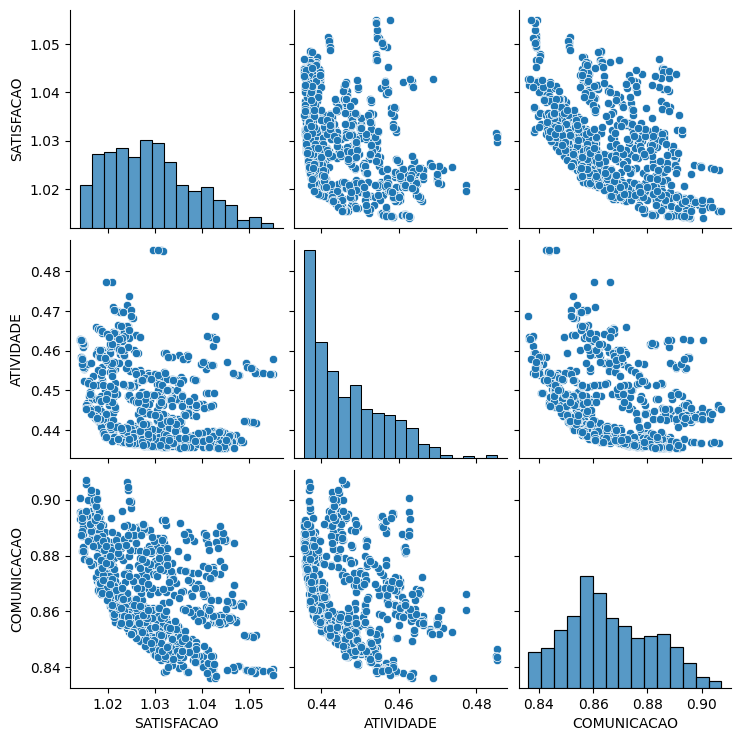

In [28]:
sns.pairplot(pd.DataFrame(data={ 'SATISFACAO': F[:, 0], 'ATIVIDADE': F[:, 1], 'COMUNICACAO': F[:, 2]}))

Analisando convergência.

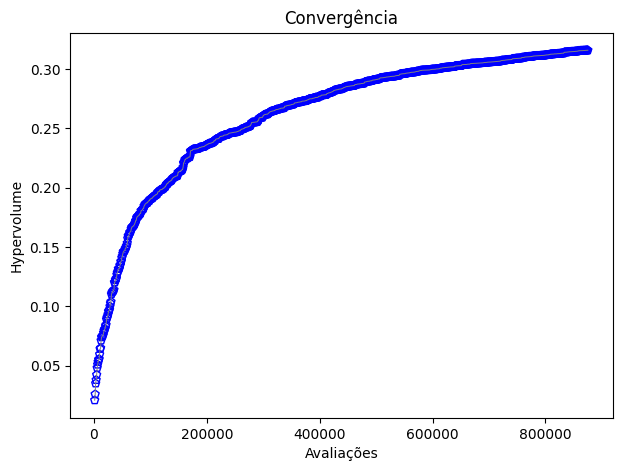

In [29]:
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

x = np.array(variabilidade_atual['SATISFACAO'])
y = np.array(variabilidade_atual['ATIVIDADE'])
z = np.array(variabilidade_atual['COMUNICACAO'])

metric = Hypervolume(ref_point= np.array([x, y, z]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hist_F = []
n_evals = []
for hist in resultado.history:
    n_evals.append(hist.evaluator.n_eval)
    feas = np.where(hist.opt.get("feasible"))[0]
    hist_F.append(hist.opt.get("F")[feas])

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='gray', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='blue', marker="p")
plt.title("Convergência")
plt.xlabel("Avaliações")
plt.ylabel("Hypervolume")
plt.show()

In [30]:
hypervolume_final = metric.do(hist_F[-1])
print('HYPERVOLUME:', hypervolume_final)

HYPERVOLUME: 0.31599054393014353


In [31]:
df_hypervolume = pd.DataFrame()
if os.path.exists(ENDERECO_HYPERVOLUME_SOLUCOES_ENCONTRADAS):
    df_hypervolume = pd.read_csv(ENDERECO_HYPERVOLUME_SOLUCOES_ENCONTRADAS, sep=';', index_col=False, header=0)
    if len(df_hypervolume[df_hypervolume['ID'] == IDENTIFICADOR_EXECUCAO]) == 0:
        registro = { 'ID': IDENTIFICADOR_EXECUCAO }
        for key in RESUMO_EXECUCAO:
            registro[key] = RESUMO_EXECUCAO[key]
        registro['HYPERVOLUME'] = hypervolume_final
        registro['TIMESTAMP'] = datetime.now()
        novo_df = pd.DataFrame(registro, index=[registro['ID']])
        novo_df = novo_df.reset_index()[['ID', 'POP_SIZE', 'N_OFFSPRINGS', 'N_GEN', 'HYPERVOLUME', 'TIMESTAMP']]
        df_hypervolume = pd.concat([df_hypervolume, novo_df])
    else:
        print('b')
        df_hypervolume.loc[df_hypervolume['ID'] == IDENTIFICADOR_EXECUCAO, 'HYPERVOLUME'] = hypervolume_final
        df_hypervolume.loc[df_hypervolume['ID'] == IDENTIFICADOR_EXECUCAO, 'TIMESTAMP'] = datetime.now()
else:
    dados = {}
    indice = []
    for key in RESUMO_EXECUCAO:
        indice = [IDENTIFICADOR_EXECUCAO]
        dados[key] = [RESUMO_EXECUCAO[key]]
    dados['HYPERVOLUME'] = hypervolume_final
    dados['TIMESTAMP'] = datetime.now()
    df_hypervolume = pd.DataFrame(data=dados, index=[IDENTIFICADOR_EXECUCAO])
    df_hypervolume.index.name = 'ID'

In [32]:
df_hypervolume = df_hypervolume.reset_index()[['ID', 'POP_SIZE', 'N_OFFSPRINGS', 'N_GEN', 'HYPERVOLUME', 'TIMESTAMP']]
df_hypervolume.to_csv(ENDERECO_HYPERVOLUME_SOLUCOES_ENCONTRADAS, sep=';', index=False)

Analisando convergência das últimas iterações.

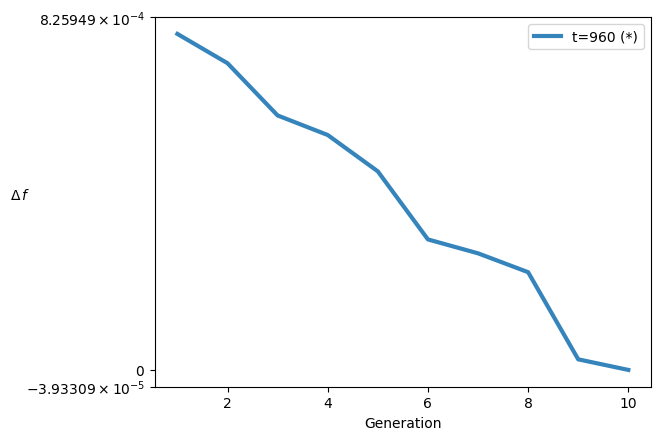

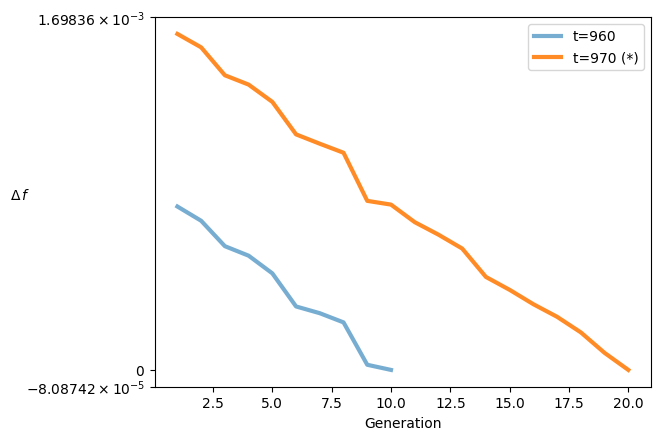

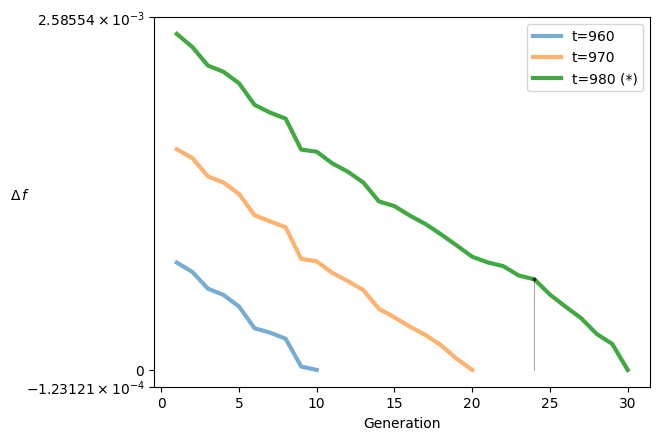

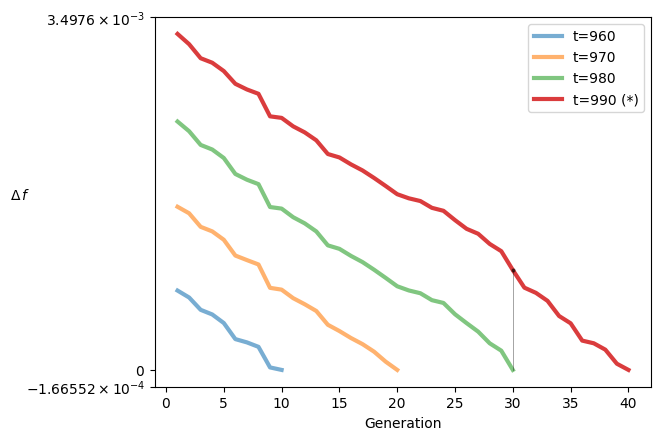

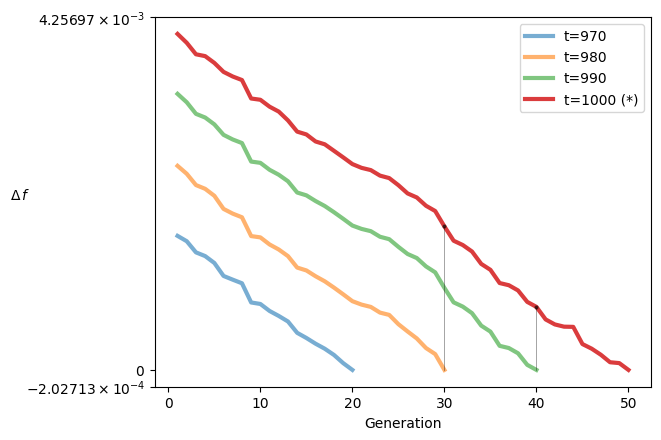

In [33]:
from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(delta_gen=10,
                        n_plots=4,
                        key_press=False,
                        do_show=True)

QUANTIDADE_ULTIMAS_ITERACOES_A_ANALISAR = 50
for h in resultado.history[len(resultado.history) - QUANTIDADE_ULTIMAS_ITERACOES_A_ANALISAR:]:
    running.update(h)

Analisando soluções ótimas.

In [34]:
tmp_f_satisfacao = []
tmp_f_atividade = []
tmp_f_comunicacao = []
times_dos_devs = []
f_inicial = df.groupby('TIME')[['SATISFACAO', 'ATIVIDADE', 'COMUNICACAO']].sum().std().to_numpy()
print('SOLUCAO ATUAL:', f_inicial)
for solucao in resultado.opt:
    df_solucao = problema.criar_solucao(solucao.X)
    f_esperada = df_solucao.groupby('TIME')[['SATISFACAO', 'ATIVIDADE', 'COMUNICACAO']].sum().std().to_numpy()
    assert np.array_equal(f_esperada, solucao.F)
    assert np.array_equal(solucao.F, problema.calcular_variabilidade_da_solucao(solucao.X))
    df_devs_solucao = df_solucao[df_solucao['ID'].isin(problema.novos['ID'])][['ID', 'TIME']]
    tmp_f_satisfacao.append(solucao.F[0])
    tmp_f_atividade.append(solucao.F[1])
    tmp_f_comunicacao.append(solucao.F[2])
    times_dos_devs.append([(id, df_devs_solucao[df_devs_solucao['ID'] == id]['TIME'].values[0]) for id in df_devs_solucao['ID']])
dados = { 'F_SATISFACAO': tmp_f_satisfacao, 'F_ATIVIDADE': tmp_f_atividade, 'F_COMUNICACAO': tmp_f_comunicacao }
for solucao in times_dos_devs:
    for time in solucao:
        if time[0] in dados.keys():
            dados[time[0]].append(time[1])
        else:
            dados[time[0]] = [time[1]]
df_solucoes_otimas = pd.DataFrame(
    data=dados,
    index=range(len(resultado.opt))
)
df_solucoes_otimas.to_csv(f'{ENDERECO_DATASET_SOLUCOES_ENCONTRADAS}{IDENTIFICADOR_EXECUCAO}.csv', sep=';', index=False)

SOLUCAO ATUAL: [1.37525278 0.70251843 1.22783874]


In [35]:
df_solucoes_otimas = pd.read_csv(f'{ENDERECO_DATASET_SOLUCOES_ENCONTRADAS}{IDENTIFICADOR_EXECUCAO}.csv', sep=';', header=0)
df_solucoes_otimas.head(5)

,F_SATISFACAO,F_ATIVIDADE,F_COMUNICACAO,Dev_10,Dev_19,Dev_21,Dev_26,Dev_30,Dev_32,Dev_34,...,Dev_280,Dev_292,Dev_310,Dev_322,Dev_329,Dev_343,Dev_346,Dev_430,Dev_459,Dev_488
0,1.020199,0.456700,0.870954,orleans,project-system,core,INDEFINIDO,razor,tye,install-scripts,...,roslyn,dotnet-api-docs,csharplang,INDEFINIDO,INDEFINIDO,docfx,aspire,docs,INDEFINIDO,maintenance-packages
1,1.019784,0.450018,0.873819,msbuild,razor,EntityFramework.Docs,csharplang,docfx,dotnet-api-docs,tye,...,roslyn,fsharp,runtime,AspNetCore.Docs,aspire,interactive,INDEFINIDO,maui,INDEFINIDO,docs
2,1.032345,0.450091,0.847054,docfx,efcore,arcade,maui,csharplang,eShop,install-scripts,...,runtime,interactive,maintenance-packages,roslyn,AspNetCore.Docs,core,razor,aspire,INDEFINIDO,aspnetcore
3,1.028051,0.444442,0.857199,orleans,efcore,docfx,INDEFINIDO,fsharp,arcade,install-scripts,...,runtime,sdk,INDEFINIDO,AspNetCore.Docs,INDEFINIDO,INDEFINIDO,aspnetcore,aspire,winforms,roslyn
4,1.029724,0.454265,0.844666,dotnet-api-docs,efcore,winforms,INDEFINIDO,sdk,arcade,install-scripts,...,runtime,interactive,installer,AspNetCore.Docs,INDEFINIDO,eShop,core,docs,aspire,roslyn


In [36]:
df_solucoes_otimas.describe()

,F_SATISFACAO,F_ATIVIDADE,F_COMUNICACAO
count,964.000000,964.000000,964.000000
mean,1.029022,0.446377,0.865910
std,0.008981,0.009527,0.015945
min,1.014019,0.435531,0.836095
25%,1.021872,0.438193,0.854523
50%,1.027911,0.443512,0.862920
75%,1.034744,0.452734,0.878017
max,1.055042,0.485438,0.907267


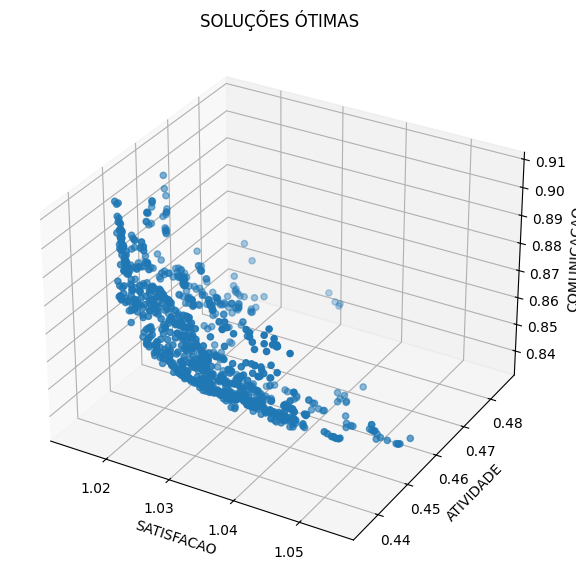

In [37]:
x = np.array([])
y = np.array([])
z = np.array([])

for solucao in resultado.opt:
    x = np.append(x, solucao.F[0])
    y = np.append(y, solucao.F[1])
    z = np.append(z, solucao.F[2])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

ax.set_xlabel('SATISFACAO')
ax.set_ylabel('ATIVIDADE')
ax.set_zlabel('COMUNICACAO')

ax.set_title("SOLUÇÕES ÓTIMAS")

p = ax.scatter(x, y, z, marker='o')

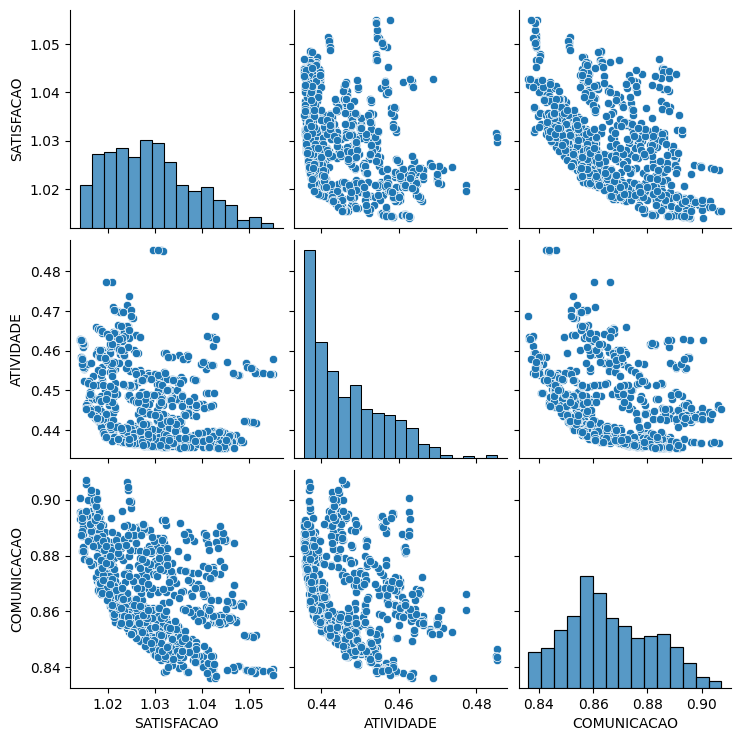

In [38]:
sns.pairplot(pd.DataFrame(data={ 'SATISFACAO': x, 'ATIVIDADE': y, 'COMUNICACAO': z}))

In [39]:
df_hypervolume = pd.read_csv(ENDERECO_HYPERVOLUME_SOLUCOES_ENCONTRADAS, sep=';', index_col=False, header=0)
df_hypervolume.sort_values(by=['HYPERVOLUME', 'N_GEN', 'POP_SIZE', 'N_OFFSPRINGS'], ascending=False).head(25)

,ID,POP_SIZE,N_OFFSPRINGS,N_GEN,HYPERVOLUME,TIMESTAMP
20,.POP_SIZE_1250.N_OFFSPRINGS_875.N_GEN_100,1250,875,100,0.336471,2024-02-01 16:55:44.725867
10,.POP_SIZE_1000.N_OFFSPRINGS_700.N_GEN_150,1000,700,150,0.335574,2024-02-01 15:52:08.846509
12,.POP_SIZE_1500.N_OFFSPRINGS_1050.N_GEN_50,1500,1050,50,0.328617,2024-02-01 16:03:44.115693
1,.POP_SIZE_100.N_OFFSPRINGS_70.N_GEN_100,100,70,100,0.323719,2024-02-01 15:34:24.780045
9,.POP_SIZE_1000.N_OFFSPRINGS_700.N_GEN_100,1000,700,100,0.323682,2024-02-01 15:47:30.365371
8,.POP_SIZE_1000.N_OFFSPRINGS_700.N_GEN_50,1000,700,50,0.323607,2024-02-01 15:44:27.394164
23,.POP_SIZE_1250.N_OFFSPRINGS_875.N_GEN_1000,1250,875,1000,0.315991,2024-02-01 17:39:11.459227
21,.POP_SIZE_1125.N_OFFSPRINGS_788.N_GEN_100,1125,788,100,0.315283,2024-02-01 17:00:22.735510
11,.POP_SIZE_1000.N_OFFSPRINGS_700.N_GEN_200,1000,700,200,0.314903,2024-02-01 15:58:04.904773
16,.POP_SIZE_1000.N_OFFSPRINGS_300.N_GEN_150,1000,300,150,0.314327,2024-02-01 16:17:12.891691
